In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import h5py
import sys
import os
import re

In [2]:
sim_base_path = "/u/jerbo/arepo/run/scaling_sims"

# Number of particles analysis (on 1 node = 72 CPUs)

## Get number of Particles and paths

In [3]:
sim_dirs = os.listdir(sim_base_path)
sim_dirs = [s for s in sim_dirs if re.search(r"sim_n.*_particles", s)]

# find all different simulations paths
sim_output_paths = [sim_base_path+"/"+i+"/output" for i in sim_dirs]

# read info on number of particles from param_music.txt_log.txt file
number_of_particles = []
for sim_dir_path in sim_dirs:
    with open(sim_base_path+"/"+sim_dir_path+"/param_music.txt_log.txt", "r") as file:
        for line in file:
            if 'levelmax' in line:
                n = int(line[-2])
                number_of_particles.append(2**(3*n))

# sort the two lists from smalles n_particles to largest
number_of_particles, sim_output_paths = zip(*sorted(zip(number_of_particles, sim_output_paths)))

print(number_of_particles)
print(sim_output_paths)

(32768, 262144, 2097152, 16777216)
('/u/jerbo/arepo/run/scaling_sims/sim_n5_particles/output', '/u/jerbo/arepo/run/scaling_sims/sim_n6_particles/output', '/u/jerbo/arepo/run/scaling_sims/sim_n7_particles/output', '/u/jerbo/arepo/run/scaling_sims/sim_n8_particles/output')


## Get CPU times

In [4]:
# get total amout of time from cpu.txt
cummulative_times = []
for i, path in enumerate(sim_output_paths):
    cummulative_times.append([])
    with open(path+"/cpu.txt", "r") as file:
        for line in file:
            if 'total' in line:
                cummulative_times[i].append(float(line.split()[3]))

# get the last cummulative time for each run = total time taken
total_times = [i[-1]*72/3600 for i in cummulative_times]  # *72 for 72 tasks in parralel and /3600 to convert to hours

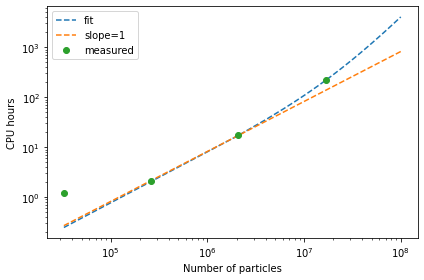

In [5]:
from scipy.optimize import curve_fit

def polynomial(x, a, b):
    return a*x + b*np.power(x, 2)

popt, pcov = curve_fit(polynomial, number_of_particles[1:], total_times[1:])
x_dummy = np.linspace(number_of_particles[0], 1e8)
plt.plot(x_dummy, polynomial(x_dummy, *popt), linestyle="--", label="fit")

time_per_particle = total_times[2]/number_of_particles[2]
plt.plot(x_dummy, time_per_particle*x_dummy, linestyle="--", label="slope=1")

plt.plot(number_of_particles, total_times, linestyle="None", marker="o", label="measured")
plt.ylabel("CPU hours")
plt.xlabel("Number of particles")
plt.xscale("log")
plt.yscale("log")
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig("./plots/cpu_time_vs_n_particles.pdf", format="PDF")
plt.show()

## Get percentages of time usage

In [6]:
# get total amout of time from cpu.txt
time_percentages_treegrav = []
time_percentages_pm_grav = []
time_percentages_domain = []
for i, path in enumerate(sim_output_paths):
    time_percentages_treegrav.append([])
    time_percentages_pm_grav.append([])
    time_percentages_domain.append([])
    with open(path+"/cpu.txt", "r") as file:
        for line in file:
            if 'treegrav' in line:
                time_percentages_treegrav[i].append(float(line.split()[-1][:-1]))
            if 'pm_grav' in line:
                time_percentages_pm_grav[i].append(float(line.split()[-1][:-1]))
            if 'domain ' in line:
                time_percentages_domain[i].append(float(line.split()[-1][:-1]))

total_percent_treegrav = [i[-1]/100 for i in time_percentages_treegrav]
total_percent_pm_grav = [i[-1]/100 for i in time_percentages_pm_grav]
total_percent_domain = [i[-1]/100 for i in time_percentages_domain]

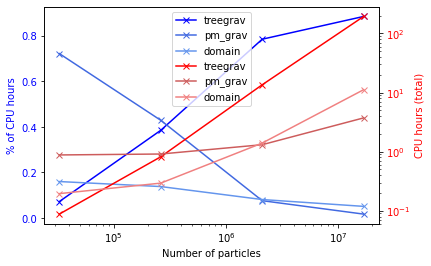

In [7]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(number_of_particles, total_percent_treegrav, marker="x", c="b", label="treegrav")
ax1.plot(number_of_particles, total_percent_pm_grav, marker="x", c="royalblue", label="pm_grav")
ax1.plot(number_of_particles, total_percent_domain, marker="x", c="cornflowerblue", label="domain")
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_ylabel("% of CPU hours", c='b')
ax1.set_xscale("log")

ax2.plot(number_of_particles, np.array(total_times)*np.array(total_percent_treegrav),
         c="r", marker="x", label="treegrav")
ax2.plot(number_of_particles, np.array(total_times)*np.array(total_percent_pm_grav),
         c="indianred", marker="x", label="pm_grav")
ax2.plot(number_of_particles, np.array(total_times)*np.array(total_percent_domain),
         c="lightcoral", marker="x", label="domain")
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylabel("CPU hours (total)", c='r')
ax2.set_yscale("log")

ax1.set_xlabel("Number of particles")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center')

# plt.savefig("./plots/cpu_percent_usage_vs_n_particles.pdf", format="PDF")
plt.show()

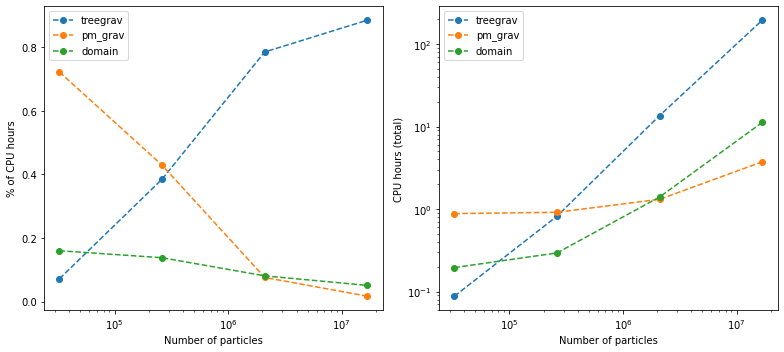

In [8]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(11, 5))

ax[0].plot(number_of_particles, total_percent_treegrav, marker="o", label="treegrav", linestyle="--")
ax[0].plot(number_of_particles, total_percent_pm_grav, marker="o", label="pm_grav", linestyle="--")
ax[0].plot(number_of_particles, total_percent_domain, marker="o", label="domain", linestyle="--")
ax[0].set_ylabel("% of CPU hours")
ax[0].set_xscale("log")
ax[0].set_xlabel("Number of particles")
ax[0].legend()

ax[1].plot(number_of_particles, np.array(total_times)*np.array(total_percent_treegrav), marker="o", label="treegrav", linestyle="--")
ax[1].plot(number_of_particles, np.array(total_times)*np.array(total_percent_pm_grav), marker="o", label="pm_grav", linestyle="--")
ax[1].plot(number_of_particles, np.array(total_times)*np.array(total_percent_domain), marker="o", label="domain", linestyle="--")
ax[1].set_ylabel("CPU hours (total)")
ax[1].set_yscale("log")
ax[1].set_xscale("log")
ax[1].set_xlabel("Number of particles")
ax[1].legend()

plt.tight_layout()
plt.savefig("./plots/cpu_time_percent_usage_vs_n_particles.pdf", format="PDF")
plt.show()

## Plot cummulative time vs steps

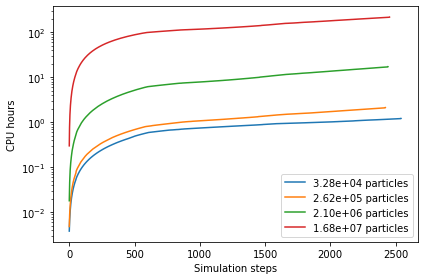

In [9]:
cummulative_times_n_particles = [np.array(i)*72/3600 for i in cummulative_times]  # conversion into cpu hours

for i in range(len(number_of_particles)):
    plt.plot(range(len(cummulative_times_n_particles[i])), cummulative_times_n_particles[i], label=f"{number_of_particles[i]:.2e} particles")

plt.ylabel("CPU hours")    
plt.xlabel("Simulation steps")
plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.savefig("./plots/cpu_time_vs_sim_steps.pdf", format="PDF")
plt.show()

In [10]:
# get total amout of time from cpu.txt
time_percentages_treegrav = []
time_percentages_pm_grav = []
time_percentages_domain = []
cummulative_times = []
path = sim_output_paths[2]
n_particles = number_of_particles[2]

with open(path+"/cpu.txt", "r") as file:
    for line in file:
        if 'treegrav' in line:
            time_percentages_treegrav.append(float(line.split()[-1][:-1]))
        if 'pm_grav' in line:
            time_percentages_pm_grav.append(float(line.split()[-1][:-1]))
        if 'domain ' in line:
            time_percentages_domain.append(float(line.split()[-1][:-1]))
        if 'total' in line:
            cummulative_times.append(float(line.split()[3]))

total_percent_treegrav = [i/100 for i in time_percentages_treegrav]
total_percent_pm_grav = [i/100 for i in time_percentages_pm_grav]
total_percent_domain = [i/100 for i in time_percentages_domain]
tot_times = [i*72/3600 for i in cummulative_times]

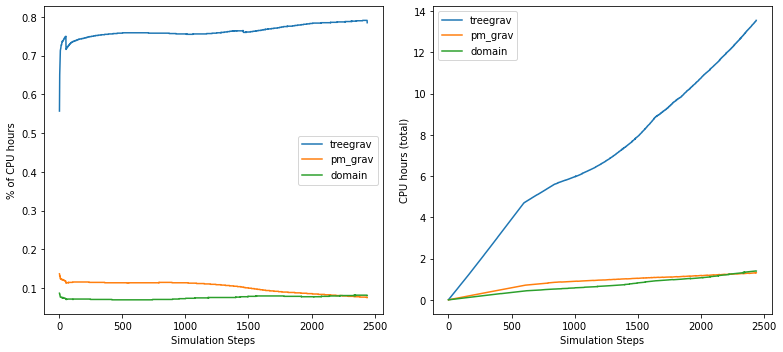

In [11]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(11, 5))

ax[0].plot(range(len(total_percent_treegrav)), total_percent_treegrav, label="treegrav")
ax[0].plot(range(len(total_percent_pm_grav)), total_percent_pm_grav, label="pm_grav")
ax[0].plot(range(len(total_percent_domain)), total_percent_domain, label="domain")
ax[0].set_ylabel("% of CPU hours")
ax[0].set_xlabel("Simulation Steps")
ax[0].legend()

ax[1].plot(range(len(total_percent_treegrav)), np.array(tot_times)*np.array(total_percent_treegrav), label="treegrav")
ax[1].plot(range(len(total_percent_pm_grav)), np.array(tot_times)*np.array(total_percent_pm_grav), label="pm_grav")
ax[1].plot(range(len(total_percent_domain)), np.array(tot_times)*np.array(total_percent_domain), label="domain")
ax[1].set_ylabel("CPU hours (total)")
# ax[1].set_yscale("log")
ax[1].set_xlabel("Simulation Steps")
ax[1].legend()

plt.tight_layout()
plt.savefig("./plots/cpu_time_percent_usage_vs_simulation_steps.pdf", format="PDF")
plt.show()

## Get scale factor - time step conversion

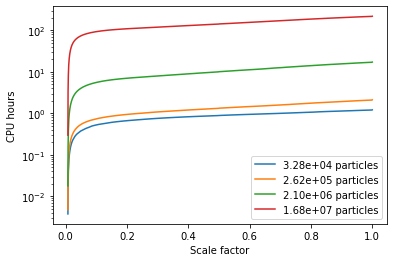

In [12]:
scale_factor_to_steps = []

for i, path in enumerate(sim_output_paths):
    scale_factor_to_steps.append([])

    with open(path+"/cpu.txt", "r") as file:
        for line in file:
            if 'Step' in line:
                scale_factor_to_steps[i].append(float(line.split()[3].replace(",", "")))

for i in range(len(number_of_particles)):
    plt.plot(scale_factor_to_steps[i], cummulative_times_n_particles[i], label=f"{number_of_particles[i]:.2e} particles")

plt.ylabel("CPU hours")    
plt.xlabel("Scale factor")
plt.yscale("log")
plt.legend()
plt.show()

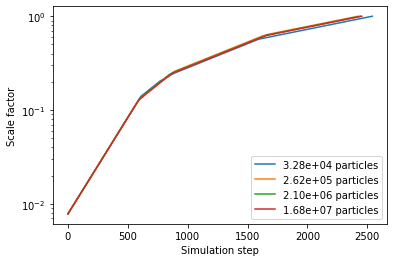

In [13]:
for i in range(len(scale_factor_to_steps)):
    plt.plot(range(len(scale_factor_to_steps[i])), scale_factor_to_steps[i], label=f"{number_of_particles[i]:.2e} particles")

plt.ylabel("Scale factor")
plt.xlabel("Simulation step")
plt.yscale("log")
plt.legend()
plt.show()

# Number of CPUs analysis ($2^{7*3}$ $\approx$ 2mil particles)

In [14]:
sim_dirs = os.listdir(sim_base_path)
sim_dirs = [s for s in sim_dirs if re.search(r"sim_n.*_cpus(?!\w)", s)]

# find all different simulations paths
sim_output_paths = [sim_base_path+"/"+i+"/output" for i in sim_dirs]

number_of_cpus = []
for i in sim_output_paths:
    with open(i+"/cpu.txt", "r") as file:
        for line in file:
            if 'CPUs:' in line:
                number_of_cpus.append(int(line.replace(",", "").split()[5]))
                break

# sort the two lists from smalles n_cpus to largest
number_of_cpus, sim_output_paths = zip(*sorted(zip(number_of_cpus, sim_output_paths)))
                
                
print(sim_output_paths)
print(number_of_cpus)

('/u/jerbo/arepo/run/scaling_sims/sim_n32_cpus/output', '/u/jerbo/arepo/run/scaling_sims/sim_n72_cpus/output', '/u/jerbo/arepo/run/scaling_sims/sim_n144_cpus/output', '/u/jerbo/arepo/run/scaling_sims/sim_n216_cpus/output', '/u/jerbo/arepo/run/scaling_sims/sim_n288_cpus/output')
(32, 72, 144, 216, 288)


## Get CPU times

In [15]:
# get total amout of time from cpu.txt
cummulative_times = []
for i, path in enumerate(sim_output_paths):
    cummulative_times.append([])
    with open(path+"/cpu.txt", "r") as file:
        for line in file:
            if 'total' in line:
                cummulative_times[i].append(float(line.split()[3]))

# get the last cummulative time for each run = total time taken
total_times = [i[-1]/3600 for i in cummulative_times]  # /3600 to convert to hours
total_times = [total_times[i]*number_of_cpus[i] for i in range(len(total_times))]
number_of_nodes = [i/72 for i in number_of_cpus]

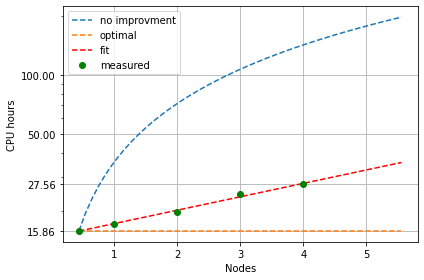

In [16]:
from scipy.optimize import curve_fit

def polynomial(x, a, b):
    return a * np.exp(b*x)

popt, pcov = curve_fit(polynomial, number_of_nodes, total_times, p0=[1 , 0.001])
x_dummy = np.linspace(number_of_nodes[0], 400/72)

fig, ax = plt.subplots()

time_per_cpu = total_times[0]/number_of_nodes[0]
ax.plot(x_dummy, time_per_cpu*x_dummy, linestyle="--", label="no improvment")
ax.plot(x_dummy, [time_per_cpu*number_of_nodes[0] for i in x_dummy], linestyle="--", label="optimal")
ax.plot(x_dummy, polynomial(x_dummy, *popt), linestyle="--", label="fit", c="r")


ax.plot(number_of_nodes, total_times, linestyle="None", marker="o", label="measured", c="g")
ax.set_ylabel("CPU hours")
ax.set_yscale("log")
ax.set_xlabel("Nodes")
ax.legend(loc="upper left")

ax.set_yticks([total_times[0], total_times[-1], 50, 100])
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.grid()
plt.tight_layout()
plt.savefig("./plots/cpu_time_vs_n_cpus.pdf", format="PDF")
plt.show()

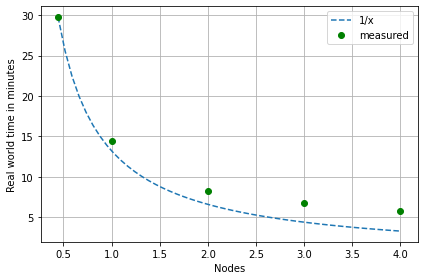

In [17]:
real_world_time = [total_times[i]/number_of_cpus[i]*60 for i in range(len(total_times))]

cpu_hours_first_datapoint = real_world_time[0] * number_of_cpus[0]

x_dummy = np.linspace(number_of_cpus[0], number_of_cpus[-1])

plt.plot(x_dummy/72, cpu_hours_first_datapoint/x_dummy, linestyle="--", label=f"1/x")
plt.plot(number_of_nodes, real_world_time, marker="o", linestyle="None", label="measured", c="g")
plt.ylabel("Real world time in minutes")
plt.xlabel("Nodes")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("./plots/real_time_vs_n_cpus.pdf", format="PDF")
plt.show()

## Get percentages of time used

In [18]:
# get total amout of time from cpu.txt
time_percentages_treegrav = []
time_percentages_pm_grav = []
time_percentages_domain = []
for i, path in enumerate(sim_output_paths):
    time_percentages_treegrav.append([])
    time_percentages_pm_grav.append([])
    time_percentages_domain.append([])
    with open(path+"/cpu.txt", "r") as file:
        for line in file:
            if 'treegrav' in line:
                time_percentages_treegrav[i].append(float(line.split()[-1][:-1]))
            if 'pm_grav' in line:
                time_percentages_pm_grav[i].append(float(line.split()[-1][:-1]))
            if 'domain ' in line:
                time_percentages_domain[i].append(float(line.split()[-1][:-1]))

total_percent_treegrav = [i[-1]/100 for i in time_percentages_treegrav]
total_percent_pm_grav = [i[-1]/100 for i in time_percentages_pm_grav]
total_percent_domain = [i[-1]/100 for i in time_percentages_domain]

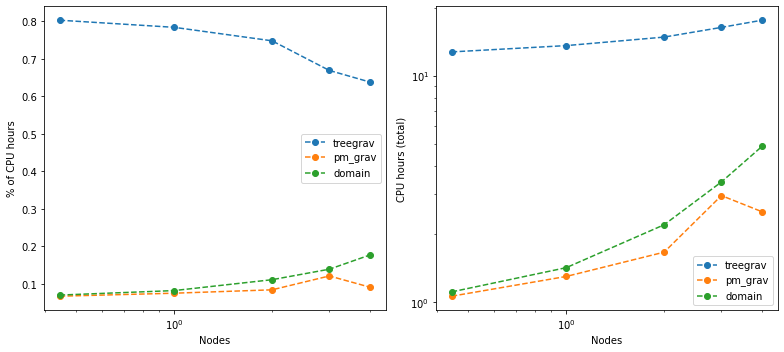

In [19]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(11, 5))

ax[0].plot(number_of_nodes, total_percent_treegrav, marker="o", label="treegrav", linestyle="--")
ax[0].plot(number_of_nodes, total_percent_pm_grav, marker="o", label="pm_grav", linestyle="--")
ax[0].plot(number_of_nodes, total_percent_domain, marker="o", label="domain", linestyle="--")
ax[0].set_ylabel("% of CPU hours")
ax[0].set_xscale("log")
ax[0].set_xlabel("Nodes")
ax[0].legend()

ax[1].plot(number_of_nodes, np.array(total_times)*np.array(total_percent_treegrav), marker="o", label="treegrav", linestyle="--")
ax[1].plot(number_of_nodes, np.array(total_times)*np.array(total_percent_pm_grav), marker="o", label="pm_grav", linestyle="--")
ax[1].plot(number_of_nodes, np.array(total_times)*np.array(total_percent_domain), marker="o", label="domain", linestyle="--")
ax[1].set_ylabel("CPU hours (total)")
ax[1].set_yscale("log")
ax[1].set_xscale("log")
ax[1].set_xlabel("Nodes")
ax[1].legend()

plt.tight_layout()
plt.savefig("./plots/cpu_time_percent_usage_vs_n_cpus.pdf", format="PDF")
plt.show()

# Number of CPUs analysis ($2^{8*3}$ $\approx$ 16mil particles)

In [20]:
sim_dirs = os.listdir(sim_base_path)
sim_dirs = [s for s in sim_dirs if re.search(r"sim_n.*_cpus_higher_res", s)]

# find all different simulations paths
sim_output_paths = [sim_base_path+"/"+i+"/output" for i in sim_dirs]

number_of_cpus = []
for i in sim_output_paths:
    with open(i+"/cpu.txt", "r") as file:
        for line in file:
            if 'CPUs:' in line:
                number_of_cpus.append(int(line.replace(",", "").split()[5]))
                break

# sort the two lists from smalles n_cpus to largest
number_of_cpus, sim_output_paths = zip(*sorted(zip(number_of_cpus, sim_output_paths)))
                
                
print(sim_output_paths)
print(number_of_cpus)

('/u/jerbo/arepo/run/scaling_sims/sim_n144_cpus_higher_res/output', '/u/jerbo/arepo/run/scaling_sims/sim_n216_cpus_higher_res/output', '/u/jerbo/arepo/run/scaling_sims/sim_n288_cpus_higher_res/output', '/u/jerbo/arepo/run/scaling_sims/sim_n432_cpus_higher_res/output')
(144, 216, 288, 432)


In [21]:
# get total amout of time from cpu.txt
cummulative_times = []
for i, path in enumerate(sim_output_paths):
    cummulative_times.append([])
    with open(path+"/cpu.txt", "r") as file:
        for line in file:
            if 'total' in line:
                cummulative_times[i].append(float(line.split()[3]))

# get the last cummulative time for each run = total time taken
total_times = [i[-1]/3600 for i in cummulative_times]  # /3600 to convert to hours
total_times = [total_times[i]*number_of_cpus[i] for i in range(len(total_times))]
number_of_nodes = [i/72 for i in number_of_cpus]

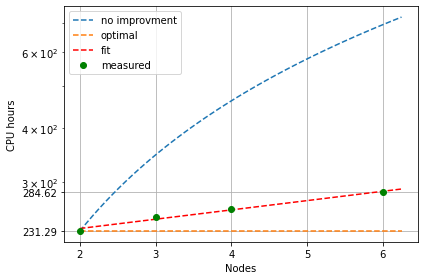

In [22]:
from scipy.optimize import curve_fit

def polynomial(x, a, b):
    return a * np.exp(b*x)

popt, pcov = curve_fit(polynomial, number_of_nodes, total_times, p0=[1 , 0.001])
x_dummy = np.linspace(number_of_cpus[0], 450)

fig, ax = plt.subplots()

time_per_cpu = total_times[0]/number_of_cpus[0]
ax.plot(x_dummy/72, time_per_cpu*x_dummy, linestyle="--", label="no improvment")
ax.plot(x_dummy/72, [time_per_cpu*number_of_cpus[0] for i in x_dummy], linestyle="--", label="optimal")
ax.plot(x_dummy/72, polynomial(x_dummy/72, *popt), linestyle="--", label="fit", c="r")


ax.plot(number_of_nodes, total_times, linestyle="None", marker="o", label="measured", c="g")
ax.set_ylabel("CPU hours")
ax.set_yscale("log")
ax.set_xlabel("Nodes")
ax.legend(loc="upper left")

ax.set_yticks([total_times[0], total_times[-1]])
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.grid()
plt.tight_layout()
plt.savefig("./plots/cpu_time_vs_n_cpus_higher_res.pdf", format="PDF")
plt.show()

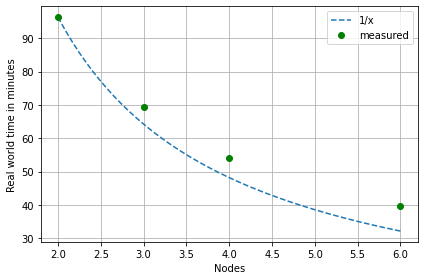

In [23]:
real_world_time = [total_times[i]/number_of_cpus[i]*60 for i in range(len(total_times))]

cpu_hours_first_datapoint = real_world_time[0] * number_of_cpus[0]

x_dummy = np.linspace(number_of_cpus[0], number_of_cpus[-1])

plt.plot(x_dummy/72, cpu_hours_first_datapoint/x_dummy, linestyle="--", label=f"1/x")
plt.plot(number_of_nodes, real_world_time, marker="o", linestyle="None", label="measured", c="g")
plt.ylabel("Real world time in minutes")
plt.xlabel("Nodes")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("./plots/real_time_vs_n_cpus_higher_res.pdf", format="PDF")
plt.show()

In [24]:
# get total amout of time from cpu.txt
time_percentages_treegrav = []
time_percentages_pm_grav = []
time_percentages_domain = []
for i, path in enumerate(sim_output_paths):
    time_percentages_treegrav.append([])
    time_percentages_pm_grav.append([])
    time_percentages_domain.append([])
    with open(path+"/cpu.txt", "r") as file:
        for line in file:
            if 'treegrav' in line:
                time_percentages_treegrav[i].append(float(line.split()[-1][:-1]))
            if 'pm_grav' in line:
                time_percentages_pm_grav[i].append(float(line.split()[-1][:-1]))
            if 'domain ' in line:
                time_percentages_domain[i].append(float(line.split()[-1][:-1]))

total_percent_treegrav = [i[-1]/100 for i in time_percentages_treegrav]
total_percent_pm_grav = [i[-1]/100 for i in time_percentages_pm_grav]
total_percent_domain = [i[-1]/100 for i in time_percentages_domain]

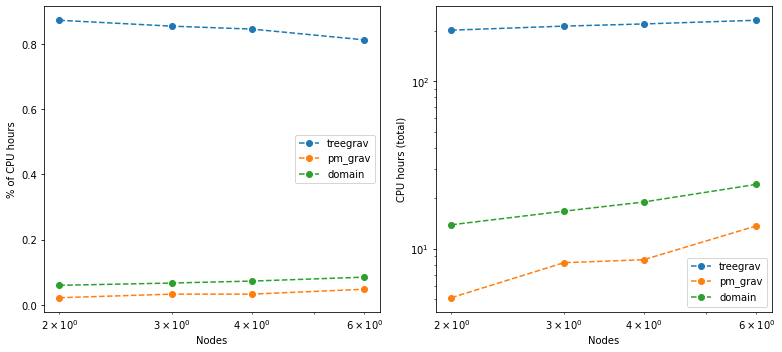

In [25]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(11, 5))

ax[0].plot(number_of_nodes, total_percent_treegrav, marker="o", label="treegrav", linestyle="--")
ax[0].plot(number_of_nodes, total_percent_pm_grav, marker="o", label="pm_grav", linestyle="--")
ax[0].plot(number_of_nodes, total_percent_domain, marker="o", label="domain", linestyle="--")
ax[0].set_ylabel("% of CPU hours")
ax[0].set_xscale("log")
ax[0].set_xlabel("Nodes")
ax[0].legend()

ax[1].plot(number_of_nodes, np.array(total_times)*np.array(total_percent_treegrav), marker="o", label="treegrav", linestyle="--")
ax[1].plot(number_of_nodes, np.array(total_times)*np.array(total_percent_pm_grav), marker="o", label="pm_grav", linestyle="--")
ax[1].plot(number_of_nodes, np.array(total_times)*np.array(total_percent_domain), marker="o", label="domain", linestyle="--")
ax[1].set_ylabel("CPU hours (total)")
ax[1].set_yscale("log")
ax[1].set_xscale("log")
ax[1].set_xlabel("Nodes")
ax[1].legend()

plt.tight_layout()
plt.savefig("./plots/cpu_time_percent_usage_vs_n_cpus_higher_res.pdf", format="PDF")
plt.show()

## Num of CPUs both resolutions

In [26]:
sim_dirs = os.listdir(sim_base_path)
sim_dirs = [s for s in sim_dirs if re.search(r"sim_n.*_cpus", s)]

# find all different simulations paths
sim_output_paths = [sim_base_path+"/"+i+"/output" for i in sim_dirs]

number_of_cpus = []
n_particles = []
for i in sim_output_paths:
    with open(i+"/cpu.txt", "r") as file:
        for line in file:
            if 'CPUs:' in line:
                number_of_cpus.append(int(line.replace(",", "").split()[5]))
                break
    
    with open(i+"/../param_music.txt_log.txt") as file:
        for line in file:
            if 'levelmin' in line:
                n_particles.append(int(line.split()[-1]))
                break

# sort the two lists from smalles n_cpus to largest
number_of_cpus, sim_output_paths, n_particles = zip(*sorted(zip(number_of_cpus, sim_output_paths, n_particles)))
                
                
print(sim_output_paths)
print(number_of_cpus)
print(n_particles)

('/u/jerbo/arepo/run/scaling_sims/sim_n32_cpus/output', '/u/jerbo/arepo/run/scaling_sims/sim_n72_cpus/output', '/u/jerbo/arepo/run/scaling_sims/sim_n144_cpus/output', '/u/jerbo/arepo/run/scaling_sims/sim_n144_cpus_higher_res/output', '/u/jerbo/arepo/run/scaling_sims/sim_n216_cpus/output', '/u/jerbo/arepo/run/scaling_sims/sim_n216_cpus_higher_res/output', '/u/jerbo/arepo/run/scaling_sims/sim_n288_cpus/output', '/u/jerbo/arepo/run/scaling_sims/sim_n288_cpus_higher_res/output', '/u/jerbo/arepo/run/scaling_sims/sim_n432_cpus_higher_res/output')
(32, 72, 144, 144, 216, 216, 288, 288, 432)
(7, 7, 7, 8, 7, 8, 7, 8, 8)


In [27]:
sim_output_paths_split = []
number_of_cpus_split = []
n_particles_split = []
for i, n in enumerate(set(n_particles)):
    sim_output_paths_split.append([])
    number_of_cpus_split.append([])
    n_particles_split.append(n)
    for j in range(len(sim_output_paths)):
        if n_particles[j] == n:
            sim_output_paths_split[i].append(sim_output_paths[j])
            number_of_cpus_split[i].append(number_of_cpus[j])
            
print(sim_output_paths_split)
print(number_of_cpus_split)
print(n_particles_split)

[['/u/jerbo/arepo/run/scaling_sims/sim_n144_cpus_higher_res/output', '/u/jerbo/arepo/run/scaling_sims/sim_n216_cpus_higher_res/output', '/u/jerbo/arepo/run/scaling_sims/sim_n288_cpus_higher_res/output', '/u/jerbo/arepo/run/scaling_sims/sim_n432_cpus_higher_res/output'], ['/u/jerbo/arepo/run/scaling_sims/sim_n32_cpus/output', '/u/jerbo/arepo/run/scaling_sims/sim_n72_cpus/output', '/u/jerbo/arepo/run/scaling_sims/sim_n144_cpus/output', '/u/jerbo/arepo/run/scaling_sims/sim_n216_cpus/output', '/u/jerbo/arepo/run/scaling_sims/sim_n288_cpus/output']]
[[144, 216, 288, 432], [32, 72, 144, 216, 288]]
[8, 7]


In [28]:
# get total amout of time from cpu.txt
cummulative_times = []
for j in range(len(n_particles_split)):
    cummulative_times.append([])
    for i, path in enumerate(sim_output_paths_split[j]):
        cummulative_times[j].append([])
        with open(path+"/cpu.txt", "r") as file:
            for line in file:
                if 'total' in line:
                    cummulative_times[j][i].append(float(line.split()[3]))
total_times = []
for j in range(len(n_particles_split)):
    total_times.append([])
    # get the last cummulative time for each run = total time taken
    total_times[j] = [i[-1]/3600 for i in cummulative_times[j]]  # /3600 to convert to hours
    total_times[j] = [total_times[j][i]*number_of_cpus_split[j][i] for i in range(len(total_times[j]))]

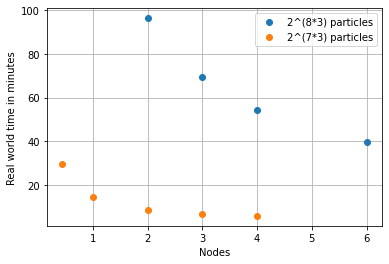

In [29]:
real_world_time = []
number_of_nodes = []
for j in range(len(n_particles_split)):
    real_world_time.append([])
    number_of_nodes.append([])
    real_world_time[j] = [total_times[j][i]/number_of_cpus_split[j][i]*60 for i in range(len(total_times[j]))]
    
    number_of_nodes[j] = [i/72 for i in number_of_cpus_split[j]]
    
    plt.plot(number_of_nodes[j], real_world_time[j], marker="o", linestyle="None", label=f"2^({n_particles_split[j]}*3) particles")

plt.ylabel("Real world time in minutes")
plt.xlabel("Nodes")
plt.grid()
plt.legend()
# plt.savefig("./plots/real_time_vs_n_cpus_both_res.pdf", format="PDF")
plt.show()

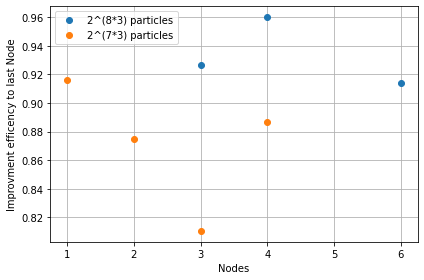

In [30]:
time_improvement = []
for j in range(len(n_particles_split)):
    time_improvement.append([])
    for i in range(1, len(real_world_time[j])):
        node_factor = number_of_nodes[j][i-1]/number_of_nodes[j][i]
        cpu_improvment_factor = real_world_time[j][i-1]/real_world_time[j][i]
        
        time_improvement[j].append(node_factor*cpu_improvment_factor)

    plt.plot(number_of_nodes[j][1:], time_improvement[j], linestyle="None", marker="o", label=f"2^({n_particles_split[j]}*3) particles")

plt.ylabel("Improvment efficency to last Node")
plt.xlabel("Nodes")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("./plots/real_time_improvment_n_nodes.pdf", format="PDF")
plt.show()

## With Gas Simulations

In [31]:
sim_base_path = "/u/jerbo/arepo/run/scaling_sims_with_gas"

In [32]:
sim_dirs = os.listdir(sim_base_path)
sim_dirs = [s for s in sim_dirs if re.search(r"sim_n.*_particles", s)]


# find all different simulations paths
sim_output_paths = [sim_base_path+"/"+i+"/output" for i in sim_dirs]

# read info on number of particles from param_music.txt_log.txt file
number_of_particles = []
for sim_dir_path in sim_dirs:
    with open(sim_base_path+"/"+sim_dir_path+"/param_music.txt_log.txt", "r") as file:
        for line in file:
            if 'levelmax' in line:
                n = int(line[-2])
                number_of_particles.append(2**(3*n))

# sort the two lists from smalles n_particles to largest
number_of_particles, sim_output_paths = zip(*sorted(zip(number_of_particles, sim_output_paths)))

print(number_of_particles)
print(sim_output_paths)

(262144, 2097152, 16777216)
('/u/jerbo/arepo/run/scaling_sims_with_gas/sim_n6_particles/output', '/u/jerbo/arepo/run/scaling_sims_with_gas/sim_n7_particles/output', '/u/jerbo/arepo/run/scaling_sims_with_gas/sim_n8_particles/output')


In [33]:
# get total amout of time from cpu.txt
cummulative_times = []
for i, path in enumerate(sim_output_paths):
    cummulative_times.append([])
    with open(path+"/cpu.txt", "r") as file:
        for line in file:
            if 'total' in line:
                cummulative_times[i].append(float(line.split()[3]))

# get the last cummulative time for each run = total time taken
total_times = [i[-1]/3600 for i in cummulative_times]  # *72 for 72 tasks in parralel and /3600 to convert to hours

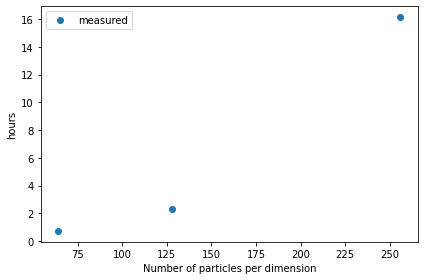

In [34]:
plt.plot(np.power(number_of_particles, 1/3), total_times, linestyle="None", marker="o", label="measured")
plt.ylabel("hours")
plt.xlabel("Number of particles per dimension")
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig("./plots_with_gas/cpu_time_vs_n_particles.pdf", format="PDF")
plt.show()